In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

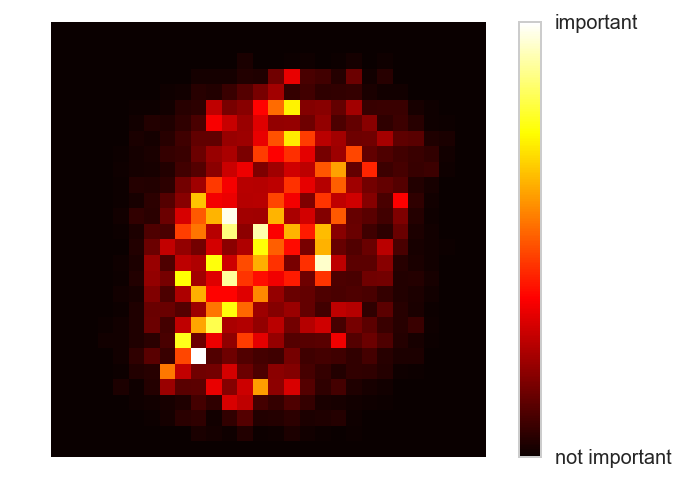

In [10]:
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier

mnist = fetch_mldata('MNIST original')
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['not important', 'important'])
 
plt.show()

1. 많은 머신러닝 문제는 훈련 샘플의 특성은 수천에서 수백만개가 될 수 있습니다. 이는 훈련을 느리게 할 뿐만 아니라, 좋은 솔루션을 찾기 어렵게 만듭니다. 이를 차원의 저주라 합니다.
    
1. MNIST문제에서 외곽에 위치한 픽셀은 흰색으로 완전히 제거해도 숫자 분류 작업에 영향을 주지 않습니다. 게다가 인접한 두 픽셀은 연관이 클 가능성이 있기에 두 픽셀을 하나의 픽셀로 합치더라도 잃는 정보는 많지 않을 것입니다.

1. 차원을 축소시킬 경우 일부 정보가 유실됩니다. 훈련속도는 빨라지겠지만 모델의 성능은 나빠질 가능성이 있습니다. 그러므로 차원 축소 전 훈련이 너무 느린지 확인해야 합니다.

1. 훈련속도를 높이는 것 외에 차원축소는 데이터 시각화에 아주 유용합니다. 그래프로 표현하여 군집같은 시각적인 패턴을 감지 할 수 있습니다.

## 8.1 차원의 저주

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영

In [22]:
from sklearn.decomposition import PCA
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [23]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

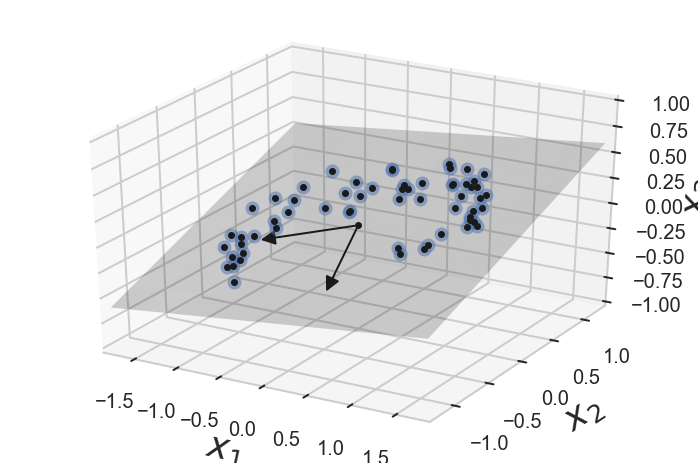

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X[:, 2]]
X3D_below = X[X[:, 2] <= X[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X[i, 2]:
        ax.plot([X[i][0], X[i][0]], [X[i][1], X[i][1]], [X[i][2], X[i][2]], "k-")
    else:
        ax.plot([X[i][0], X[i][0]], [X[i][1], X[i][1]], [X[i][2], X[i][2]], "k-", color="#505050")
    
ax.plot(X[:, 0], X[:, 1], X[:, 2], "k+")
ax.plot(X[:, 0], X[:, 1], X[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

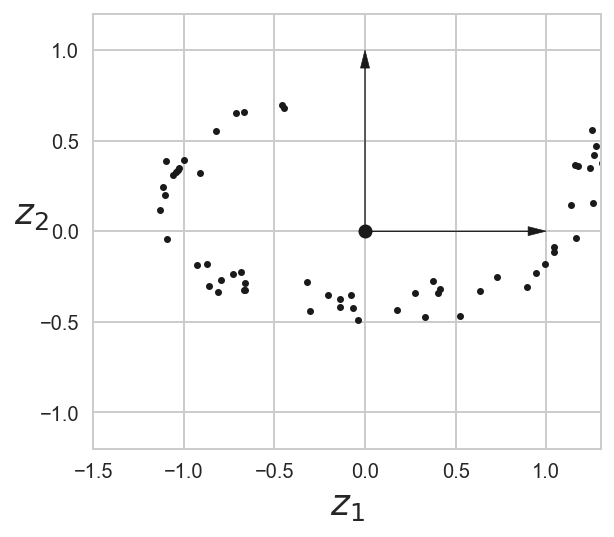

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True) 

훈련 샘플이 무돈 차원에 걸쳐 균일하게 퍼져 있지 않습니다. 대다수 특성은 거의 변화가 없는반면(특히 MNIST) 다른 특성들은 서로 강하게 연관되어 있습니다. 결과적으로 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 부분공간에 위치합니다

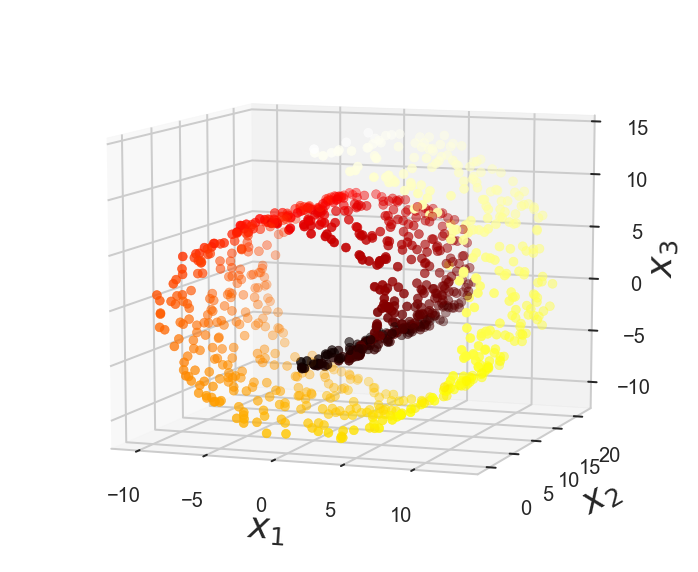

In [28]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

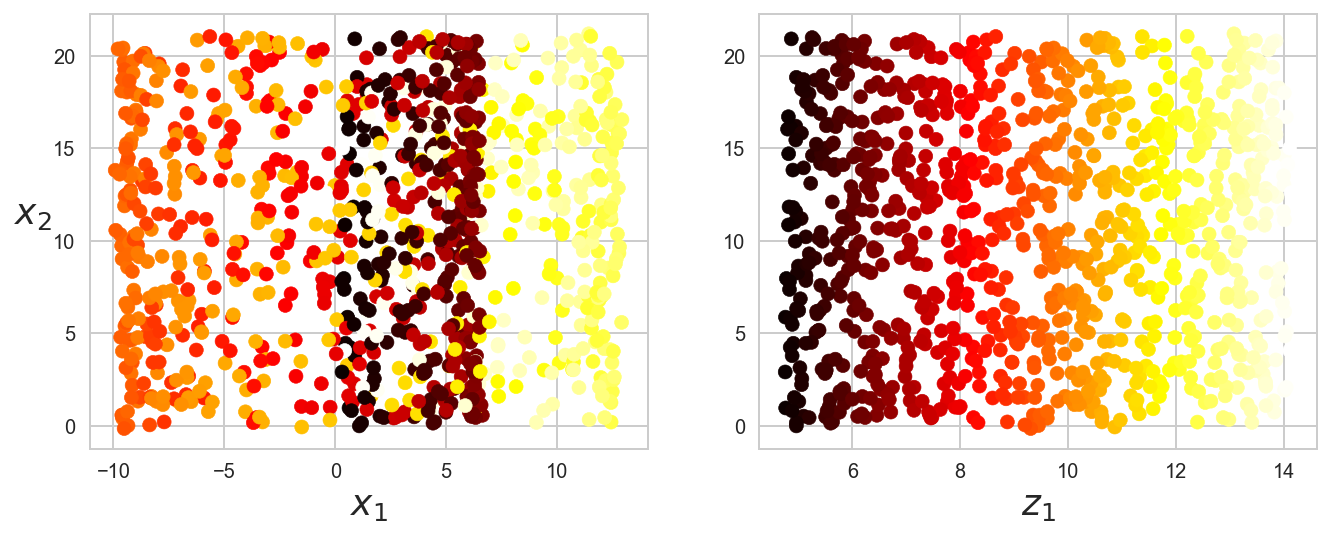

In [31]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot) 
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot) 
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

그냥 평면에 투영시키면 층이 서로 뭉개지기ㅔ 됩니다. 우리가 원하는 바는 오른쪽 그림처럼 스위스 롤을 펼친 데이터셋을 얻는 것입니다

### 8.2.2 매니폴드 학습

2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D모양입니다. 더 일반적으로 d차원 매니폴드는 국부적으로 **d차원 초평면**으로 보일 수 있는 **n차원 공간의 일부** 입니다. (d < n)

많은 차원축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 식으로 작동합니다.
이를 매니폴드 학습이라고 합니다. 
대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정또는 매니폴드 가설에 근거합니다.

훈련시키기 전 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 나은 솔루션이 되는 것은 아닙니다.

## 8.3 PCA
주성분 분석(principal componet analysis) 가장 인기있는 축소 알고리즘입니다. 먼저 데이터에 가장 가까운 초평면을 정의한 다음 데이터를 이 평면에 투영시킵니다.

### 8.3.1 분산 보존

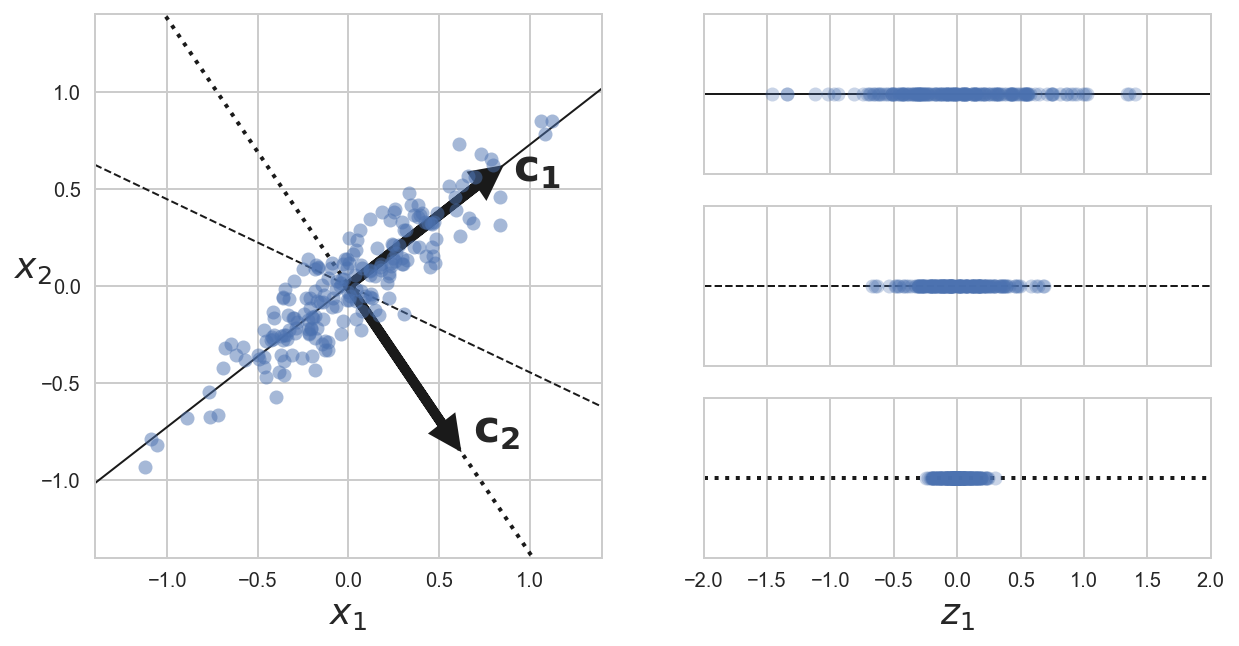

In [36]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
plt.show()

저차원의 초평면에 훈련세트를 투영하기 전에 먼저 올바른 초평면을 선택해야 합니다. 

분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적인 방법입니다. 다른 방식으로 설명하면 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축입니다.

### 8.3.2 주성분

i번째 축을 정의하는 단위 벡터를 i번째 주성분이라고 부릅니다. 위의 그림에서 c1, c2가 주성분입니다.

주성분을 찾는 방법은 특잇값분해를 이용하여 행렬 X를 $ U \cdot \sum \cdot V^T $로 분해할 수 있습니다. 여기서 찾고자 하는 모든 주성분은 V입니다.

In [40]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

### 8.3.3 d차원에 투영하기

In [41]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s) 
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [42]:
W2 = Vt.T[:, :2] # 2 * 2
X2D = X_centered.dot(W2) 
X2D_using_svd = X2D

[-2, 2, -1, 1]

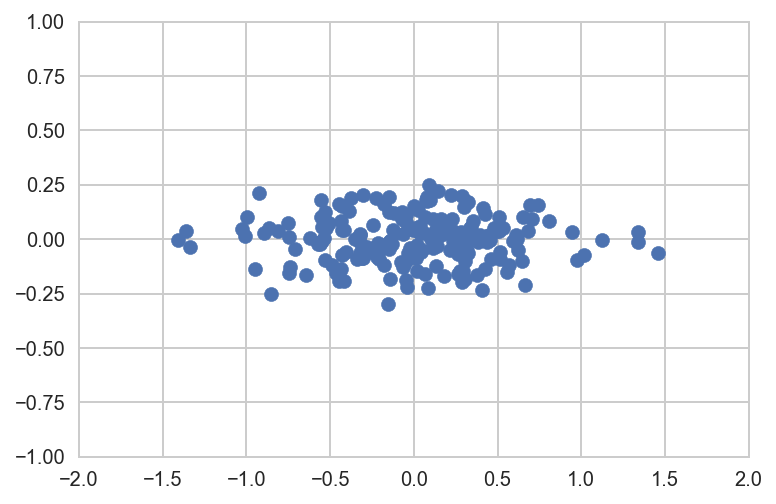

In [45]:
plt.scatter(X2D_using_svd[:, 0], X2D_using_svd[:, 1])
plt.axis([-2, 2, -1, 1])

초평면에 훈련세트를 투영하기 위해서는 행렬 $X$와 첫 $d$개의 주성분을 담은($V$의 첫 $d$열로 구성된) 행렬 $W_d$를 내적하면 됩니다.

### 8.3.4 사이킷런 사용하기

사이킷런의 pca모델은 svd 분해 방법을 사용합니다. (자동으로 데이터를 중앙으로 맞춤니다 X - x.mean())

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state=42)
X2D = pca.fit_transform(X)

In [54]:
pca.components_

array([[-0.79644131, -0.60471583],
       [ 0.60471583, -0.79644131]])

components로 주성분을 확인할 수 있습니다.
첫번째 주성분은 pca.components_.T[:, 0]이 됩니다.

### 8.3.5 설명된 분산의 비율

explained_variance_ratio_ 변수도 중요한 정보 중 하나입니다. 이 값은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타냅니다.

In [55]:
pca.explained_variance_ratio_

array([0.95369864, 0.04630136])

95%가 첫번째 축에 놓여있고 4%가 두번째 축에 놓여 있음을 알려줍니다.

### 8.3.6 적절한 차원 수 선택하기

축소할 차원 수를 임의로 정하기보다는 충분한 분산이 될때까지 더해야 할 차원의 수를 선택하는 쪽이 더 좋습니다. 시각화를 위해서는 2~3 차원이 일반적입니다.

In [58]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [59]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) #누적
d = np.argmax(cumsum >= 0.95) + 1

In [63]:
X_train.shape, d

((52500, 784), 154)

784개에서 154개로 축소 가능합니다. 

In [65]:
pca = PCA(n_components=154)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=154, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

하지만 성분의 수를 지정하기보다는 보전하려는 분산의 비율을 n_components에 0 ~ 1 사이로 설장하는 편이 훨씬 좋습니다.

In [66]:
pca = PCA(n_components=0.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

또 다른 방법은 설명된 분산을 차원 수에 대한 함수로 그리는 것입니다(cumsum을 그래프로 그리면 됩니다.) 일반적으로 그래프에는 분산의 빠른 성장이 멈추는 변곡점이 있습니다.
이 지점을 데이터넷에 내재된 고유 차원으로 생각 할 수 있습니다.

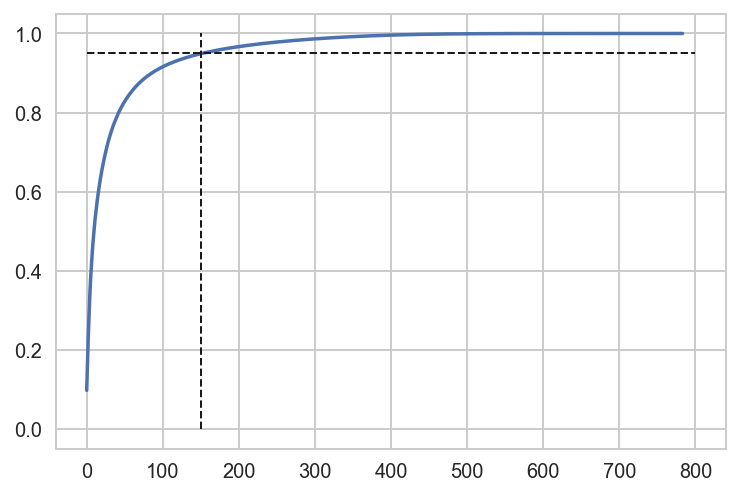

In [84]:
plt.plot(cumsum);
plt.plot([150, 150], [0, 1], "k--", linewidth=1)
plt.plot([0, 800], [0.95, 0.95], "k--", linewidth=1)

### 8.3.7 압축을 위한 PCA

차원 축소 후 훈련 세트의 크기가 줄어들었습니다. 
MNIST의 경우 분산을 95% 유지하는 조건으로 784에서 150으로 차원을 줄일 수 있었습니다. 
분류알고리즘의 속도를 크게 높일 수 있습니다.

압축된 데이터셋에 PCA투영의 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수도 있습니다. 물론 투영 과정에서 일정량의 정보를 잃어버렸기 때문에 완전한 복원은 불가능 합니다. 

원본 데이터와 재구성된 데이터 사이의 평균 제곱거리를 재구성오차라고 합니다.


In [93]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_reduced_pca = X_reduced
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5,1,'reconstruction')

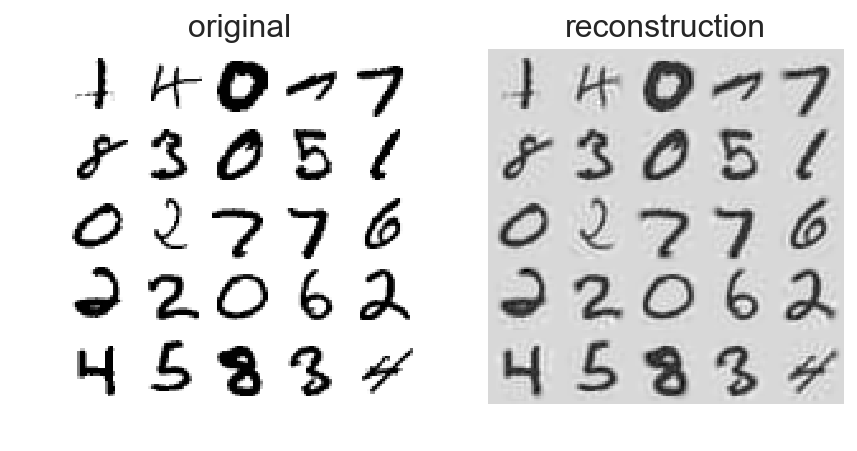

In [94]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("reconstruction", fontsize=16)

이미지 품질이 손실된 것을 볼 수 있지만 숫자 모양은 온전한 상태입니다.

### 8.3.8 점진적 PCA

pca구현의 문제는 svd 알고리즘을 실행하기 우해 전체 훈련 세트를 메모리에 올려야 한다는 것입니다.
점진적 pca 알고리즘은 미니배치로 나눈 뒤 한번에 하나씩 작업합니다.

In [95]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)
X_reduced_inc_pca = X_reduced

....................................................................................................

In [100]:
X_reduced.shape

(52500, 154)

일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과를 비교해 보겠습니다. 먼저 평균이 같은지 확인합니다:

In [101]:
np.allclose(pca.mean_, inc_pca.mean_)

True

하지만 결과는 완전히 동일하지 않습니다. 점진적 PCA는 아주 훌륭한 근사치를 제공하지만 완벽하지는 않습니다

In [102]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

또 다른 방법은 넘파이의 memmap 파이썬 클래스를 사용해 하드 디스크의 이진 파일에 저장된 ㅂ매우 큰 배열을 메모리에 들어 있는 것처럼 다루는 것입니다.

memmap() 구조를 만들고 MNIST 데이터를 복사합니다. 이는 일반적으로 별도의 프로그램에서 먼저 수행됩니다:

In [104]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

이제 memmap() 객체를 삭제하면 파이썬 종결자(finalizer)를 호출해서 데이터를 디스크에 저장하게 됩니다.

In [105]:
del X_mm

다음에 다른 프로그램에서 데이터를 로드하여 훈련에 사용합니다:

In [106]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

### 8.3.9 랜덤 PCA

확률적 알고리즘으로 첫 d개의 주성분에 대한 근삿값을 빠르게 찾습니다. d가 n보다 많이 작으면 앞선 알고리즘보다 매우 빠릅니다.

In [108]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [109]:
X_reduced.shape

(52500, 154)

## 8.4 커널 PCA

샘플을 매우 높은 고차원 공간(특성공간)으로 암묵적으로 매핑하여 서프트 벡터 머신의 비선형 분류와 회귀를 가능하게 하는 수학적 기법인 커널 트릭을 이용합니다.
고차원 특성 공간에서의 선형 결정 경계는 원본공간에서 복잡한 비선형 결정 경계에 해당합니다.

복잡한 비선형 투영으로의 차원축소를 가능하게 됩니다. 이를 커널PCA라 합니다.
투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때도 유용합니다.

In [111]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

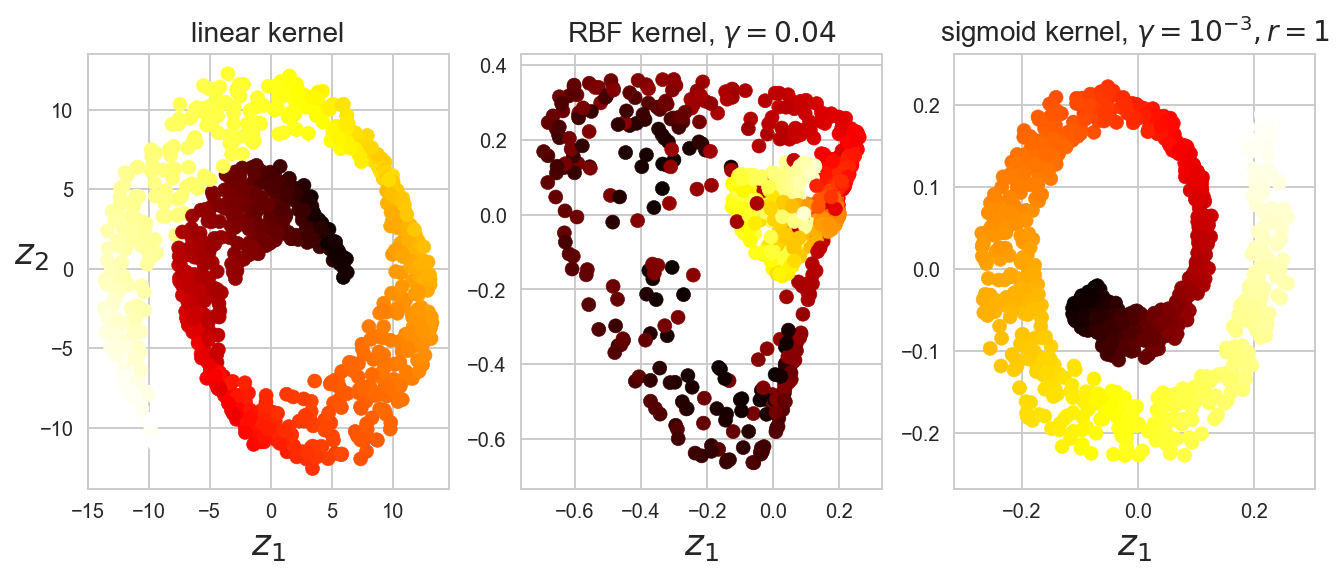

In [121]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    elif subplot == 131:
        X_reduced_lin = X_reduced
    elif subplot == 133:
        X_reduced_sig = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()

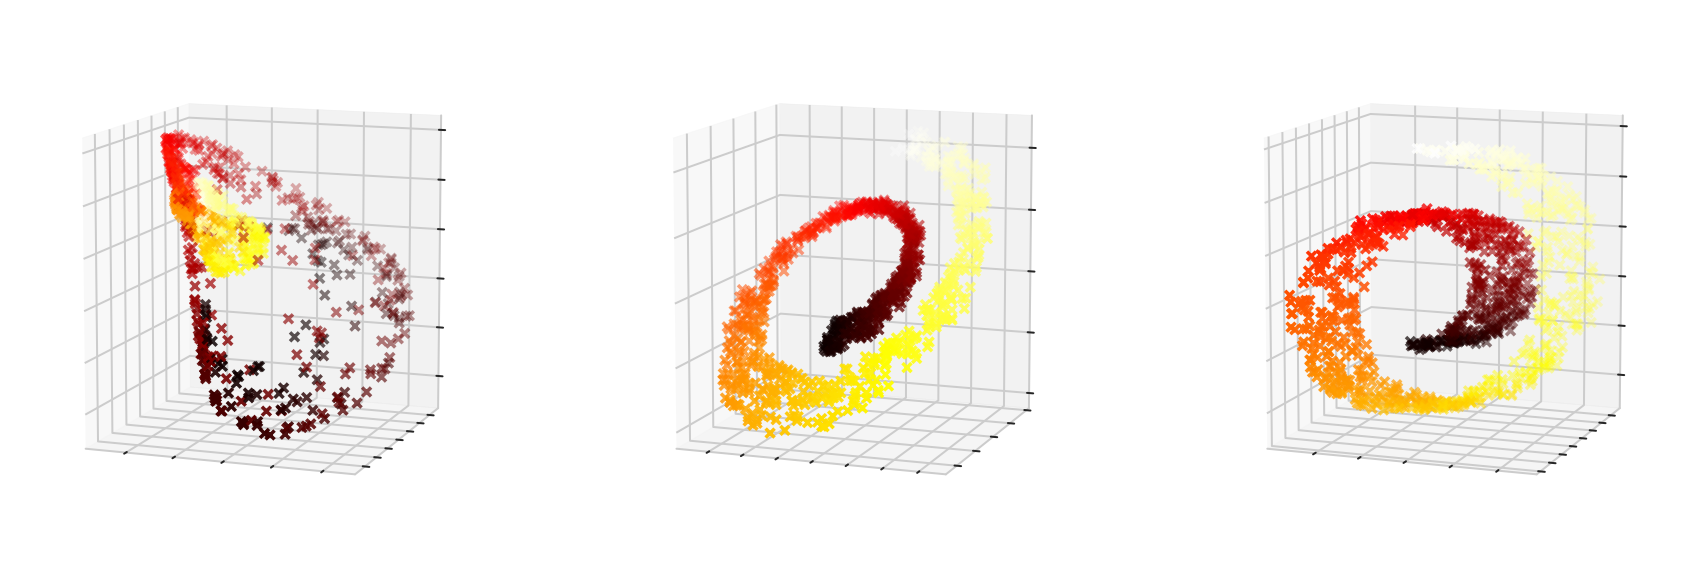

In [127]:
plt.figure(figsize=(15, 5))
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(131, projection='3d') 
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, -70)
    
X_inverse = sig_pca.inverse_transform(X_reduced_sig)
ax = plt.subplot(132, projection='3d')
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, -70)

X_inverse = lin_pca.inverse_transform(X_reduced_lin)
ax = plt.subplot(133, projection='3d')
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, -70)
plt.show()


### 8.4.1 커널 선택과 하이퍼파라미터 튜닝

kpca는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없습니다.

차원축소는 지도학습의 전처리 단계에 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 좋은 커널과 하이퍼파라미터를 찾을 수 있습니다.

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [130]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

완전한 비지도 학습 방법으로 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 찾는 방식도 있습니다.
투영된 샘플을 훈련세트로, 원본 샘플을 타깃으로 하는 지도학습 회귀 모델을 훈련시키는 것입니다. 사이킷 런에서는 fit_inverse_transform=True로 지정하면 이를 자동으로 수행합니다.

In [131]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576607

In [132]:
rbf_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

20.56565915629962

교차검증으로 그리드 탐색을 사용할 수 잇습니다.

## 8.5 LLE

지역 선형 임베딩 (local linear embedding)은 또 다른 강력한 비선형 차원 축소 기술입니다. 이전 알고리즘 처럼 투영에 의존하지 않는 매니폴드 학습입니다.

특히 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는데 잘 작동합니다.

In [134]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [135]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

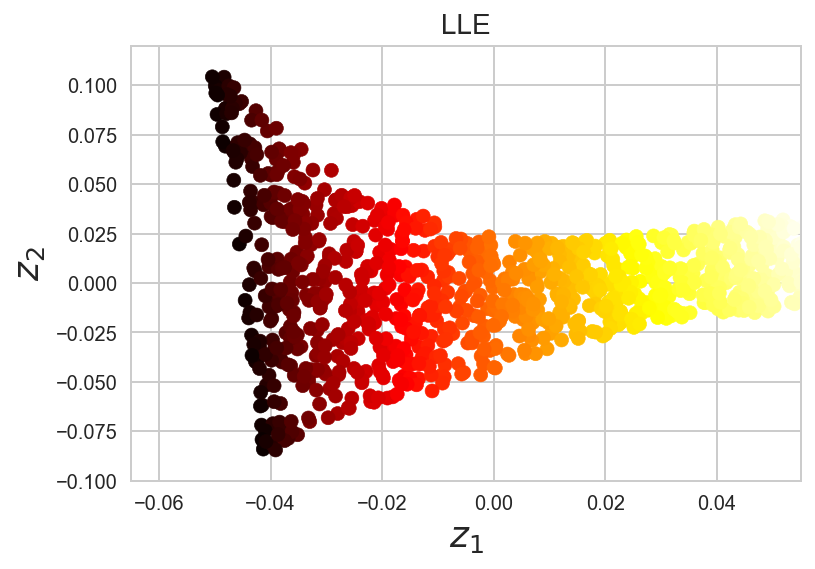

In [138]:
plt.title("LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

$X^(i)$ 에 대해 가장 가까운 k개의 샘플을 찾습니다. 그런다음 이 이웃에 대한 선형 함수로 $x^(i)$를 재구성합니다.

$x^{i}와 \sum^m_{j=1} w_{i,j}x^{(i)} $ 사이의 제곱 거리가 최소가 되는 $w_{i,j}$를 찾는 것입니다.

여기서 $x^{i}가 x^{j} $의 가장 가까운 k개 이웃중 하나가 아닐 경우에는 $w_{i,j}$는 0이 됩니다.

$$
\hat{W} = \arg\min_{w} \sum^m_{i=1} \left(x^{(i)} - \sum^m_{j=1}w_{i,j}x^{(i)} \right)^2 \\
\\
$$
$
w_{i,j} = 0 , (x^{(j)}가 x^{(i)}의 최근접 이웃 k개 중 하나가 아닐 때) \\
\sum^m_{j=1}W_{i,j} = 1   
$

LLE첫 단계는 제한이 있는 최적화 문제가 됩니다. 여기서 w는 가중치 $w_{i,j}$를 모두 담고 있는 가중치 행렬입니다. 

두번째 제약은 각 훈련 샘플 $x^(i)$에 대한 가중치를 단순히 정규화 하는 것입니다.

위 단계를 거치면 가중치 행렬 $\hat{W}$은 훈렴 샘플 사이에 있는 지역 선형 관계를 담고 있습니다. 이제 두번째 단계는 가능한 이 관계가 보존되도록 훈련 샘플을 d차원 공간(d<n)으로 매핑합니다.

샘플을 고정하고 최적의 가중치를 찾는 대신 가중치를 고정하고 저차원의 공간에 샘플 이미지의 최적 위치를 찾습니다. $Z$는 모든 $z^{i}$를 포함하는 행렬입니다.

$z^{(i)}$가 $d$차원 공간에서 $x^{(i)}$의 상이라면 가능한 $z^{(i)}$와 $\sum^m_{j=1}\hat{w}_{i,j}z^{j}$사이의 거리가 최소화되어야 합니다.

$$
Z = \arg\min_{z} \sum^m_{i=1} \left(z^{(i)} - \sum^m_{j=1}w_{i,j}z^{(i)} \right)^2 \\
$$

그러나 계산 복잡도로 인하여 대량의 데이터넷에 적용하기는 어렵습니다.

## 8.6 다른 차원 축소 기법

- 다차원 스케일링(Multidimensional Scaling, MDS)는 샘플 간의 거리를 보존하면서 차원을 축소합니다.
- lsomap은 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만듭니다. 그런 다음 샘플 간의 지오테식 거리를 유지하면서 차원을 축소합니다.
    - 지오테식 거리 : 그래프에서 두 노드 사이의 지오테식 거리는 두 노드 사이의 최단 경로를 이루는 노드의 수입니다.
- t-SNE(t-Distributed Stochastic Neighbor Embedding)는 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소합니다. 주로 시각화에 많이 사용되며 특히 고차원 공간에 있는 샘플의 군집을 시각화할 때 사용 됩니다.
- 선형판별분석(Linear Discriminant Analysis,LDA) 는 사실 분류 알고리즘입니다. 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습합니다. 이 축은 데이터가 투영되는 초평면을 정의하는 데 사용할 수 있습니다. 이 알고리즘의 장점은 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM 분류기 같은 다른 분류알고리즘을 적용하기 전에 차원을 축소시키는 데 좋습니다.

In [148]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [142]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [143]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [144]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

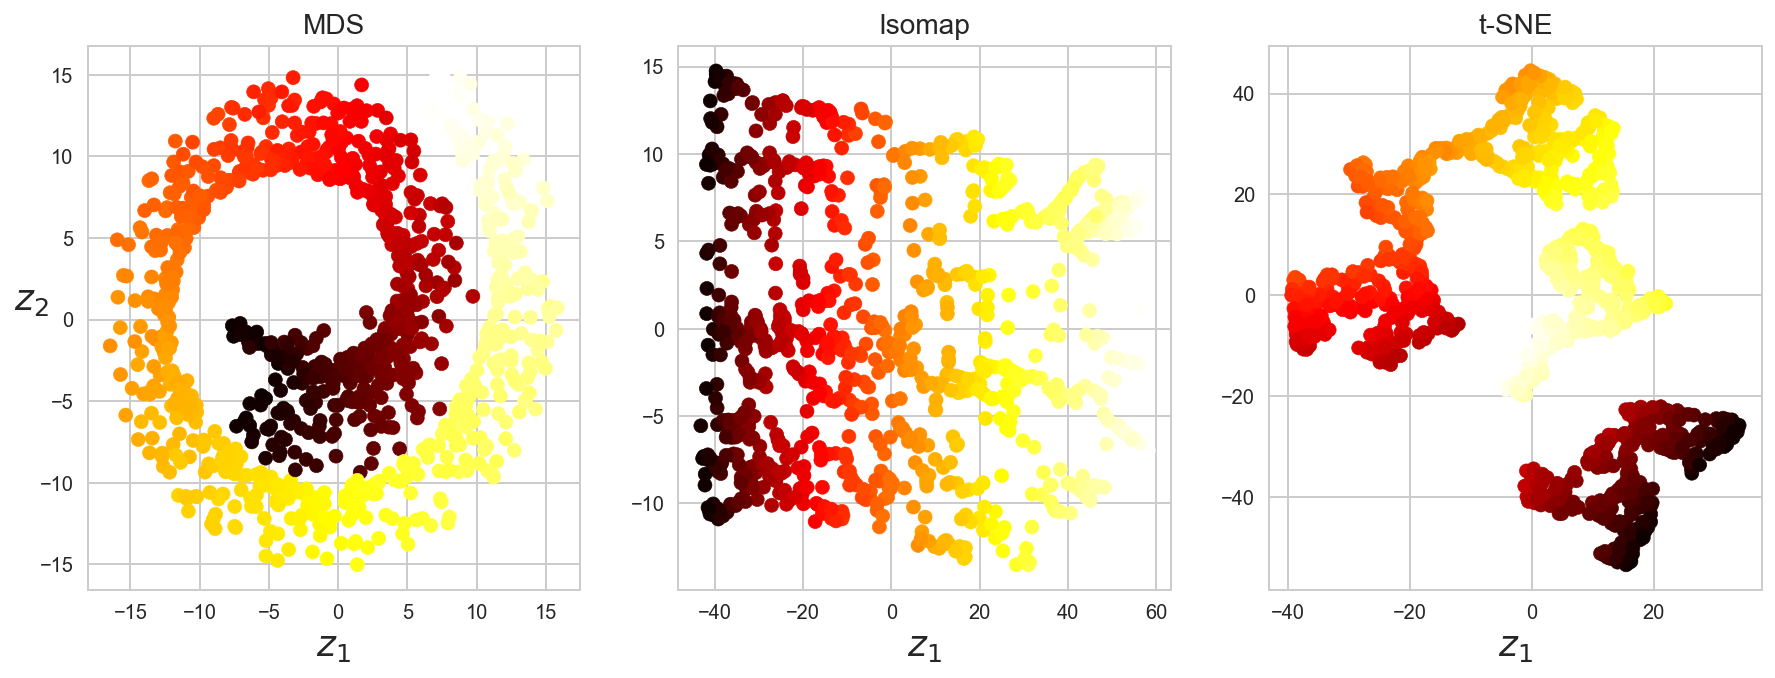

In [150]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(15,5))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## 8.7 연습문제

1.데이터셋의 차원을 축소하는 주요 목적은 무엇인가요? 대표적인 단점은 무엇인가요?

2.차원의 저주란 무엇인가요?

3.데이터셋의 차원을 축소시키고 나서 이 작업을 원복할 수 있나요? 할 수 있다면 어떻게 가능할까요? 가능하지 않다면 왜일까요?

4.매우 비선형적인 데이터셋의 차원을 축소하는 데 PCA를 사용할 수 있을까요?

5.설명된 분산을 95%로 지정한 PCA를 1000개의 차원을 가진 데이터셋에 적용한다고 가정하겠습니다. 결과 데이터셋의 차원은 얼마나 될까요?

6.기본 PCA, 점진적 PCA, 랜덤 PCA, 커널 PCA는 어느 경우에 사용될까요?

7.어떤 데이터셋에 적용한 차원 축소 알고리즘의 성능을 어떻게 평가할 수 있을까요?

8.두 개의 차원 축소 알고리즘을 연결할 수 있을까요?

9.MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다.